In [222]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from itertools import product
import matplotlib.pyplot as plt
from luminol.anomaly_detector import AnomalyDetector
from statsmodels.tsa.api import SimpleExpSmoothing
from tqdm.notebook import tqdm_notebook as log_progress
from sklearn.cluster import DBSCAN
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [223]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Model selection


Pipeline:

1. Train-test split
2. Tuning hyper parameters on the train set

$$\text{Parameters} = \text{Preparation} \times \text{Detection} \times \text{Interpolation}$$

3. Calculate RE of the best model on the test set

<img src='split.png' align='left' width=700>

In [224]:
def search_report(X, X_clean, preparation_methods, 
                  detection_methods, interpolation_methods, 
                  process_types, folds=5, folds_by_iter=3):
    
    report_prep = []
    report_prep_params = []
    report_det = []
    report_det_params = []
    report_interp = []
    report_interp_params = []
    report_process = []
    report_process_params = []
    report_re_mean = []
    report_re_std = []
    
    for det_method in log_progress(detection_methods, 
                                   desc='detection'):
        for prep_method in log_progress(preparation_methods, 
                                        desc='{}: preparation'.format(det_method), 
                                        leave=False):
            for interp_method in log_progress(interpolation_methods, 
                                              desc='{}: interpolation'.format(prep_method), 
                                              leave=False):
                for process_type in process_types:
                    for prep, det, interp, process in log_progress(
                                                        grid_search(prep_method, 
                                                                    det_method, 
                                                                    interp_method, 
                                                                    process_type), leave=False):
                        re = []
                        for fold in kfolds(X, X_clean, folds, folds_by_iter):
                            try:
                                re.append(relative_error(fold['X'], 
                                                         fold['X_true'], 
                                                         prep, 
                                                         det, 
                                                         interp, 
                                                         process))
                            except:
                                print(prep)
                                print(det)
                                print(interp)
                                print(process)
                                raise
                        report_prep.append(prep['name'])
                        report_prep_params.append(prep['params'])
                        report_det.append(det['name'])
                        report_det_params.append(det['params'])
                        report_interp.append(interp['name'])
                        report_interp_params.append(interp['params'])
                        report_process.append(process['name'])
                        report_process_params.append(process['params'])
                        report_re_mean.append(np.mean(re))
                        report_re_std.append(np.std(re))
    return pd.DataFrame({'preparation': report_prep, 
                         'preparation_params': report_prep_params,
                         'detection': report_det, 
                         'detection_params': report_det_params,
                         'interpolation': report_interp, 
                         'interpolation_params': report_interp_params,
                         'process': report_process, 
                         'process_params': report_process_params,
                         'RE_mean': report_re_mean, 
                         'RE_std': report_re_std,})

def kfolds(X, X_true, k, m):
    folds = []
    n = X.shape[0]//k
    for i in range(k-m+1):
        folds.append(
            {
                'X': X[i*n:(i+m)*n], 
                'X_true': X_true[i*n:(i+m)*n]
            }
        )
    return folds

def relative_error(X, X_true, prep, det, interp, process):
    if process['name'] == 'loop':
        X_clean = X.copy()
        for _ in range(process['params']['n_iterations']):
            X_prep = prepare(X_clean, prep)
            anomalies = detect_anomalies(X_prep, det)
            X_clean = interpolate(X_clean, anomalies, interp)
    return (
        mean_squared_error(X_true, X_clean, squared=False) 
        / 
        mean_squared_error(X_true, X, squared=False)
    )

def grid_search(prep_method, det_method, interp_method, process_type):
    param_values = []
    append_prep_values(param_values, prep_method)
    append_det_values(param_values, det_method)
    append_interp_values(param_values, interp_method)
    append_process_values(param_values, process_type)
    param_lists = list(product(*param_values))
    grid = []
    for param_list in param_lists:
        temp = {
            'prep': {
                'name': prep_method, 
                'params': {}}, 
            'det': {
                'name': det_method,
                'params': {}}, 
            'interp': {
                'name': interp_method, 
                'params': {}},
            'process': {
                'name': process_type, 
                'params': {}}}
        for param in param_list:
            temp[param['type']]['params'][param['param']] = param['value']
        grid.append((temp['prep'], temp['det'], temp['interp'], temp['process']))
    return grid

In [279]:
preparation_methods = {
    'norm',
    'exp_smooth',
    'mov_avg',
    'add_decomp',
    'stl_decomp',
    'neigh_diff',
    'random_forest',
    'grad_boost',
    'linear_reg',
    'ridge_reg',
    #'prophet'
}

detection_methods = {
    'threshold',
    'luminol',
    'luminol_default',
    'dbscan',
    #'svm',
    #'elliptic_envelope',
    #'isolation_forest',
    #'local_outlier_factor',
    #'adtk'
}

interpolation_methods = {
    'linear',
    'cubic',
    #'quadratic'
}

process_types = {'loop'}

In [277]:
def append_prep_values(param_values, method):
    
    if method == 'norm':
        return None
    
    if method == 'neigh_diff':
        return None
    
    if method == 'exp_smooth':
        param_values.append([
            {'type': 'prep', 
             'name': 'exp_smooth', 
             'param': 'alpha', 
             'value': i} for i in np.linspace(0.1, 0.9, 5)])
    
    if method == 'mov_avg':
        param_values.append([
            {'type': 'prep', 
             'name': 'mov_avg', 
             'param': 'window_size', 
             'value': i} for i in [3, 7, 14, 20, 30]])
    
    if method == 'add_decomp':
        param_values.append([
            {'type': 'prep', 
             'name': 'add_decomp', 
             'param': 'period', 
             'value': i} for i in [3, 7, 14, 20, 30]])
    
    if method == 'stl_decomp':
        param_values.append([
            {'type': 'prep', 
             'name': 'stl_decomp', 
             'param': 'period', 
             'value': i} for i in [3, 7, 14, 20, 30]])
        param_values.append([
            {'type': 'prep', 
             'name': 'stl_decomp', 
             'param': 'seasonal', 
             'value': i} for i in [7, 15, 21]])
        
    if method == 'random_forest':
        param_values.append([
            {'type': 'prep', 
             'name': 'random_forest', 
             'param': 'window_size', 
             'value': i} for i in [3, 7, 14, 20, 30]])
        param_values.append([
            {'type': 'prep', 
             'name': 'random_forest', 
             'param': 'alpha', 
             'value': i} for i in [0.3]])
        param_values.append([
            {'type': 'prep', 
             'name': 'random_forest', 
             'param': 'max_depth', 
             'value': i} for i in [3, 5, 10, 20]])
        
    if method == 'grad_boost':
        param_values.append([
            {'type': 'prep', 
             'name': 'grad_boost', 
             'param': 'window_size', 
             'value': i} for i in [3, 7, 14, 20, 30]])
        param_values.append([
            {'type': 'prep', 
             'name': 'grad_boost', 
             'param': 'alpha', 
             'value': i} for i in [0.3]])
        param_values.append([
            {'type': 'prep', 
             'name': 'grad_boost', 
             'param': 'learning_rate', 
             'value': i} for i in np.linspace(0.1, 0.9, 9)])
        param_values.append([
            {'type': 'prep', 
             'name': 'grad_boost', 
             'param': 'n_estimators', 
             'value': i} for i in [10, 20, 50, 100]])
    
    if method == 'linear_reg':
        param_values.append([
            {'type': 'prep', 
             'name': 'linear_reg', 
             'param': 'window_size', 
             'value': i} for i in [3, 7, 14, 20, 30]])
        param_values.append([
            {'type': 'prep', 
             'name': 'linear_reg', 
             'param': 'alpha', 
             'value': i} for i in [0.3]])
        param_values.append([
            {'type': 'prep', 
             'name': 'linear_reg', 
             'param': 'normalize', 
             'value': i} for i in [True, False]])
    
    if method == 'ridge_reg':
        param_values.append([
            {'type': 'prep', 
             'name': 'ridge_reg', 
             'param': 'window_size', 
             'value': i} for i in [3, 7, 14, 20, 30]])
        param_values.append([
            {'type': 'prep', 
             'name': 'ridge_reg', 
             'param': 'alpha', 
             'value': i} for i in [0.3]])
        param_values.append([
            {'type': 'prep', 
             'name': 'ridge_reg', 
             'param': 'normalize', 
             'value': i} for i in [True, False]])
        param_values.append([
            {'type': 'prep', 
             'name': 'ridge_reg', 
             'param': 'ridge_alpha', 
             'value': i} for i in [1]])
        param_values.append([
            {'type': 'prep', 
             'name': 'ridge_reg', 
             'param': 'solver', 
             'value': i} for i in ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']])
        param_values.append([
            {'type': 'prep', 
             'name': 'ridge_reg', 
             'param': 'max_iter', 
             'value': i} for i in [10, 100, 500, 1000]])

In [267]:
def append_det_values(param_values, method):
    if method == 'threshold':
        param_values.append([
            {'type': 'det', 
             'name': 'threshold', 
             'param': 'elbow_decay', 
             'value': i} for i in np.linspace(0.001, 0.010, 10)])
    
    if method == 'luminol_default':
        param_values.append([
            {'type': 'det', 
             'name': 'luminol_default', 
             'param': 'score_threshold', 
             'value': i} for i in np.linspace(0.005, 0.1, 5)])
        param_values.append([
            {'type': 'det', 
             'name': 'luminol_default', 
             'param': 'reverse', 
             'value': i} for i in [True, False]])
        param_values.append([
            {'type': 'det', 
             'name': 'luminol_default', 
             'param': 'algorithm_name', 
             'value': i} for i in ['default_detector']])
    
    if method == 'luminol':
        param_values.append([
            {'type': 'det', 
             'name': 'luminol', 
             'param': 'score_threshold', 
             'value': i} for i in np.linspace(0.005, 0.1, 5)])
        param_values.append([
            {'type': 'det', 
             'name': 'luminol', 
             'param': 'reverse', 
             'value': i} for i in [True, False]])
        param_values.append([
            {'type': 'det', 
             'name': 'luminol', 
             'param': 'algorithm_name', 
             'value': i} for i in ['derivative_detector', 'exp_avg_detector']])
        param_values.append([
            {'type': 'det', 
             'name': 'luminol', 
             'param': 'smoothing_factor', 
             'value': i} for i in np.linspace(0.1, 0.9, 4)])
    
    if method == 'dbscan':
        return None

In [268]:
def append_interp_values(param_values, method):
    if method == 'linear':
        return None
    if method == 'cubic':
        return None

In [269]:
def append_process_values(param_values, method):
    if method == 'loop':
        param_values.append([
            {'type': 'process', 
             'name': 'loop', 
             'param': 'n_iterations', 
             'value': i} for i in [1, 2, 3]])

def prepare(X, method):
    if method['name'] == 'norm':
        return norm(X, method['params'])
    if method['name'] == 'neigh_diff':
        return neigh_diff(X, method['params'])
    if method['name'] == 'exp_smooth':
        return exp_smooth(X, method['params'])
    if method['name'] == 'mov_avg':
        return mov_avg(X, method['params'])
    if method['name'] == 'add_decomp':
        return add_decomp(X, method['params'])
    if method['name'] == 'stl_decomp':
        return stl_decomp(X, method['params'])
    if method['name'] == 'random_forest':
        return random_forest(X, method['params'])
    if method['name'] == 'grad_boost':
        return grad_boost(X, method['params'])
    if method['name'] == 'linear_reg':
        return linear_reg(X, method['params'])
    if method['name'] == 'ridge_reg':
        return ridge_reg(X, method['params'])
    raise Exception('{} not supported'.format(method['name']))

def detect_anomalies(X, method):
    if method['name'] == 'threshold':
        return threshold(X, method['params'])
    if method['name'] == 'luminol':
        return luminol(X, method['params'], False)
    if method['name'] == 'luminol_default':
        return luminol(X, method['params'], True)
    if method['name'] == 'dbscan':
        return dbscan(X, method['params'])
    raise Exception('{} not supported'.format(method['name']))
    
def interpolate(X, anomalies, method):
    if method['name'] == 'linear':
        return linear(X, method['params'], anomalies)
    if method['name'] == 'cubic':
        return cubic(X, method['params'], anomalies)
    raise Exception('{} not supported'.format(method['name']))

In [270]:
def norm(X, params):
    return X / np.linalg.norm(X)

def neigh_diff(X, params):
    X_diff = np.concatenate(([0], (X[1:]) - X[:-1]))
    return X_diff / np.linalg.norm(X_diff)

def exp_smooth(X, params):
    alpha = params['alpha']
    fit = SimpleExpSmoothing(X).fit(alpha)
    X_smooth = fit.predict(0, X.shape[0] - 1)
    fit = SimpleExpSmoothing(X_smooth[::-1]).fit(alpha)
    X_smooth = fit.predict(0, X.shape[0] - 1)[::-1]

    X_diff = X - X_smooth
    return X_diff / np.linalg.norm(X_diff)

def mov_avg(X, params):
    X_smooth = []
    for i in range(0, len(X)):
        s = i - params['window_size'] if i - params['window_size'] >= 0 else 0
        X_smooth.append(np.mean(X[s:i+1], axis=0))
    return np.array(X_smooth) / np.linalg.norm(X_smooth)

def add_decomp(X, params):
    decomposition = seasonal_decompose(X, model='additive', period=params['period'])
    X_resid = decomposition.resid.copy()
    X_resid = np.nan_to_num(X_resid)
    return X_resid / np.linalg.norm(X_resid)

def stl_decomp(X, params):
    stl = STL(X_clean, period=params['period'], seasonal=params['seasonal'])
    decomposition = stl.fit()
    X_resid = decomposition.resid.copy()
    X_resid = np.nan_to_num(X_resid)
    return X_resid / np.linalg.norm(X_resid)

def random_forest(X, params):
    n = params['window_size']
    X_train = [[i for i in X[j:j+n]] for j in range(X.shape[0] - n)]
    X_train = np.array(X_train)
    Y_train = X[n:]
    reg = RandomForestRegressor(random_state=0, max_depth=params['max_depth'])
    reg.fit(X_train, Y_train)
    Y_pred = reg.predict(X_train)
    
    alpha = params['alpha']
    fit = SimpleExpSmoothing(X[:n]).fit(alpha)
    X_smooth = fit.predict(0, n-1)
    fit = SimpleExpSmoothing(X_smooth[::-1]).fit(alpha)
    X_smooth = fit.predict(0, n-1)[::-1]
    
    X_diff = X - np.concatenate([X_smooth, Y_pred])
    return X_diff / np.linalg.norm(X_diff)

def grad_boost(X, params):
    n = params['window_size']
    X_train = [[i for i in X[j:j+n]] for j in range(X.shape[0] - n)]
    X_train = np.array(X_train)
    Y_train = X[n:]
    reg = GradientBoostingRegressor(learning_rate=params['learning_rate'], n_estimators=params['n_estimators'])
    reg.fit(X_train, Y_train)
    Y_pred = reg.predict(X_train)
    
    alpha = params['alpha']
    fit = SimpleExpSmoothing(X[:n]).fit(alpha)
    X_smooth = fit.predict(0, n-1)
    fit = SimpleExpSmoothing(X_smooth[::-1]).fit(alpha)
    X_smooth = fit.predict(0, n-1)[::-1]
    
    X_diff = X - np.concatenate([X_smooth, Y_pred])
    return X_diff / np.linalg.norm(X_diff)

def linear_reg(X, params):
    n = params['window_size']
    X_train = [[i for i in X[j:j+n]] for j in range(X.shape[0] - n)]
    X_train = np.array(X_train)
    Y_train = X[n:]
    reg = LinearRegression(normalize=params['normalize'])
    reg.fit(X_train, Y_train)
    Y_pred = reg.predict(X_train)
    
    alpha = params['alpha']
    fit = SimpleExpSmoothing(X[:n]).fit(alpha)
    X_smooth = fit.predict(0, n-1)
    fit = SimpleExpSmoothing(X_smooth[::-1]).fit(alpha)
    X_smooth = fit.predict(0, n-1)[::-1]
    
    X_diff = X - np.concatenate([X_smooth, Y_pred])
    return X_diff / np.linalg.norm(X_diff)

def ridge_reg(X, params):
    n = params['window_size']
    X_train = [[i for i in X[j:j+n]] for j in range(X.shape[0] - n)]
    X_train = np.array(X_train)
    Y_train = X[n:]
    reg = Ridge(random_state=0, 
                alpha=params['ridge_alpha'], 
                normalize=params['normalize'], 
                solver=params['solver'], 
                max_iter=params['max_iter'])
    reg.fit(X_train, Y_train)
    Y_pred = reg.predict(X_train)
    
    alpha = params['alpha']
    fit = SimpleExpSmoothing(X[:n]).fit(alpha)
    X_smooth = fit.predict(0, n-1)
    fit = SimpleExpSmoothing(X_smooth[::-1]).fit(alpha)
    X_smooth = fit.predict(0, n-1)[::-1]
    
    X_diff = X - np.concatenate([X_smooth, Y_pred])
    return X_diff / np.linalg.norm(X_diff)


In [271]:
def threshold(X, params):
    t_space = np.linspace(0, X.max(), 100)
    av = X.mean()
    size_space = np.array([((X <= av - t) | (av + t <= X)).sum() for t in t_space])
    diff = size_space[1:] - size_space[:-1]
    best_t = t_space[np.argwhere(diff > -params['elbow_decay'] * X.shape[0])[0][0]]
    return np.argwhere((X <= av - best_t) | (av + best_t <= X))

def luminol(X, params, default):
    algorithm_params = None
    if not default:
        algorithm_params = {'smoothing_factor': params['smoothing_factor']}
    detector = AnomalyDetector(
        dict(enumerate(X)),
        algorithm_name=params['algorithm_name'],
        score_threshold=params['score_threshold'],
        algorithm_params=algorithm_params)
    if params['reverse']:
        reversed_detector = AnomalyDetector(
            dict(enumerate(X[::-1])),
            algorithm_name=params['algorithm_name'],
            score_threshold=params['score_threshold'],
            algorithm_params=algorithm_params)
    anomalies = np.array([0]*X.shape[0])
    for a in detector.get_anomalies():
        for t in range(a.start_timestamp, a.end_timestamp):
            anomalies[t] += 1
    if params['reverse']:
        for a in reversed_detector.get_anomalies():
            for t in range(a.start_timestamp, a.end_timestamp):
                anomalies[-t+1] += 1
    return np.argwhere(anomalies > 0)

def dbscan(X, params):
    n = 1000 # train set size
    X_copy = np.reshape(X.tolist(), (X.shape[0], 1))
    # fit eps
    eps_space = np.linspace(0.00001, 0.0003, 50)
    cluster_size = []
    for eps in eps_space:
        dbscan = DBSCAN(eps=eps).fit(X_copy[:n])
        largest_size = 0
        for label in set(dbscan.labels_):
            len_set = (dbscan.labels_ == label).sum()
            if largest_size < len_set:
                largest_size = len_set
        cluster_size.append(largest_size / n * 100)
    cluster_size = np.array(cluster_size)
    best_eps = eps_space[np.argmax(cluster_size[1:] - cluster_size[:-1]) + 1]
    # clustering
    dbscan = DBSCAN(eps=best_eps).fit(X_copy)
    # updating
    largest_size = 0
    largest_cluster = None
    for label in set(dbscan.labels_):
        len_set = (dbscan.labels_ == label).sum()
        if largest_size < len_set:
            largest_size = len_set
            largest_cluster = label
    return np.argwhere(dbscan.labels_ != largest_cluster)

In [272]:
def linear(X, params, anomalies):
    X_clean = X.copy()
    X_clean[anomalies] = None
    X_clean = pd.Series(X_clean).interpolate().values
    X_clean = pd.Series(X_clean).fillna(method='ffill').values
    X_clean = pd.Series(X_clean).fillna(method='bfill').values
    X_clean = pd.Series(X_clean).fillna(X.mean()).values
    return X_clean

def cubic(X, params, anomalies):
    X_clean = X.copy()
    X_clean[anomalies] = None
    if X_clean.shape[0] - np.isnan(X_clean).sum() < 4:
        X_clean = pd.Series(X_clean).fillna(X.mean()).values
    else:
        X_clean = pd.Series(X_clean).interpolate(method='cubic').values
        X_clean = pd.Series(X_clean).fillna(method='ffill').values
        X_clean = pd.Series(X_clean).fillna(method='bfill').values
    return X_clean

In [273]:
sample = pd.read_csv('../data/sample4.csv')

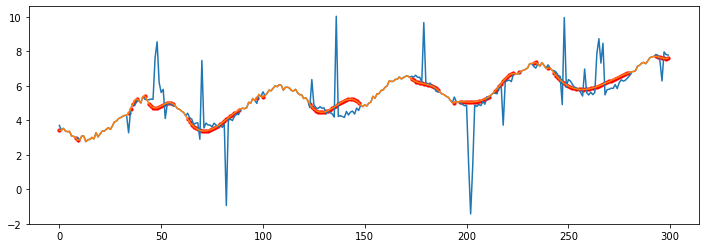

0.6656233926258915

In [275]:
X_clean = sample.X.values[285:1139].copy()
X_true = sample.Truth.values[285:1139]
X = sample.X.values[285:1139]

for _ in range(1):
    X_prep = prepare(X_clean, {'name': 'ridge_reg', 'params': {
        'window_size': 10, 
        'alpha': 0.3, 
        'normalize': False,
        'ridge_alpha': 1,
        'solver': 'svd',
        'max_iter': 10
    }})
    anomalies = detect_anomalies(X_prep, {'name': 'luminol_default', 'params': {
        'score_threshold': 0.2, 
        'reverse': True, 
        'algorithm_name': 'default_detector'
    }})
    X_clean = interpolate(X_clean, anomalies, {'name': 'cubic', 'params': {}})

plt.figure(figsize=(12, 4))
plt.plot(X[:300])
plt.plot(X_clean[:300])
plt.scatter(anomalies[anomalies<300], X_clean[anomalies[anomalies<300]], color='r', s=10)
plt.show()

mean_squared_error(X_true, X_clean, squared=False) / mean_squared_error(X_true, X, squared=False)

In [235]:
X_clean = pd.Series([None, None, None , None]).interpolate(method='cubic').values

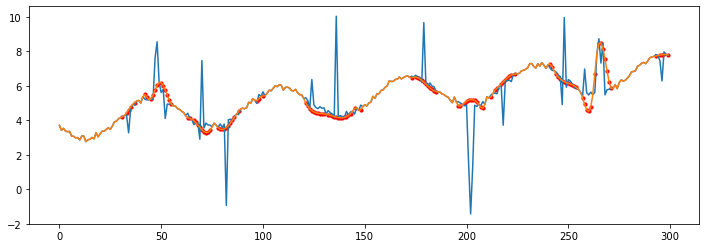

0.37755169974756864

In [236]:
X_clean = sample.X.values[285:1139].copy()
X_true = sample.Truth.values[285:1139]
X = sample.X.values[285:1139]

for _ in range(1):
    X_prep = prepare(X_clean, {'name': 'stl_decomp', 'params': {'period': 3, 'seasonal': 7}})
    anomalies = detect_anomalies(X_prep, {'name': 'dbscan', 'params': {}})
    X_clean = interpolate(X_clean, anomalies, {'name': 'cubic', 'params': {}})

plt.figure(figsize=(12, 4))
plt.plot(X[:300])
plt.plot(X_clean[:300])
plt.scatter(anomalies[anomalies<300], X_clean[anomalies[anomalies<300]], color='r', s=10)
plt.show()

mean_squared_error(X_true, X_clean, squared=False) / mean_squared_error(X_true, X, squared=False)

In [237]:
X_clean = sample.X.values[285:1139].copy()
X_true = sample.Truth.values[285:1139]
X = sample.X.values[285:1139]

for _ in range(1):
    X_prep = prepare(X_clean, {'name': 'neigh_diff', 'params': {}})
    anomalies = detect_anomalies(X_prep, {'name': 'threshold',
                                          'params': {'elbow_decay': 0.002}})
    X_clean = interpolate(X_clean, anomalies, {'name': 'cubic', 'params': {}})

plt.figure(figsize=(12, 4))
plt.plot(X[:200])
plt.plot(X_clean[:200])
plt.scatter(anomalies[anomalies<200], X_clean[anomalies[anomalies<200]], color='r', s=10)
plt.show()

mean_squared_error(X_true, X_clean, squared=False) / mean_squared_error(X_true, X, squared=False)

0.5046447712252823

In [280]:
sr = search_report(sample.X.values,
              sample.Truth.values,
              preparation_methods,
              detection_methods,
              interpolation_methods, 
              process_types, 5, 3)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'name': 'ridge_reg', 'params': {'window_size': 14, 'alpha': 0.3, 'normalize': False, 'ridge_alpha': 1, 'solver': 'svd', 'max_iter': 100}}
{'name': 'threshold', 'params': {'elbow_decay': 0.001}}
{'name': 'cubic', 'params': {}}
{'name': 'loop', 'params': {'n_iterations': 3}}



KeyboardInterrupt: 

In [ ]:
sr.sort_values('RE_mean').to_excel('search_report.xlsx')
sr.sort_values('RE_mean')

In [ ]:
relative_error(
    sample.X.values,
    sample.Truth.values,
    {'name': 'neigh_diff', 'params': {'ord': None}},
    {'name': 'threshold', 'params': {'elbow_decay': 0.007}},
    {'name': 'linear', 'params': {}},
    {'name': 'loop', 'params': {'n_iterations': 3}})

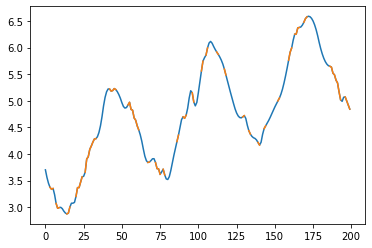

In [42]:
X_clean[anomalies] = None
pd.Series(X_clean[:200]).interpolate(method='quadratic').plot()
pd.Series(X_clean[:200]).plot()

In [47]:
[1, 2, 3, 4][:10000]

[1, 2, 3, 4]